In [1]:
import sys
sys.path.append('./../../')
sys.path.append('./..')
sys.path.append('./../../designer/script/')


from film import FreeFormFilm, BaseFilm, TwoMaterialFilm, EqOTFilm
from design import BaseDesign
from spectrum import BaseSpectrum, Spectrum
from optimizer.adam import AdamFreeFormOptimizer

from analyze_utils.make_design import make_edgefilter_design, make_reflection_design, make_triband_filter_design, get_minus_filter_spec
from utils.loss import calculate_RMS_f_spec
from analyze_utils.result_io import save, load
from analyze_utils.structure import plot_layer_thickness

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy
import pickle

In [2]:
N = 10000

def plot_FT(film: BaseFilm, ax):
    wls = np.linspace(1 / 40, 1 / 3000, N)
    wls = 1 / wls

    R = film.get_spec(0., wls).get_R()
    T = film.get_spec(0., wls).get_T()
    Q = R / T
    # Q = R
    x = np.fft.fftfreq(wls.shape[0], 2 * (1 / wls[0] - 1 / wls[-1]) / wls.shape[0])
    y = np.abs(np.fft.fft(Q)) ** 2
    y /= y.sum()
    ax.plot(x, y)
    # ax.set_xlim(None, None)
    ax.set_ylabel('a.u.')
    ax.set_xlabel('freq of k: nm (~tau_i) (larger wl range)')

    # ax.set_xscale('log')
    ax.set_xlim(0, 2 * 2e4)
    ax.set_yscale('log')
    ax.set_ylim(1e-6, None)

def plot_FT_masked(spec, ax):

    wls_o_i = 1 / spec.WLS
    m = 10
    wls_pad_left = 1 / np.linspace(wls_o_i[0], wls_o_i[0] + m * (wls_o_i[0] - wls_o_i[-1]), m * N)
    wls_pad_right = 1 / np.linspace(wls_o_i[-1] - m * (wls_o_i[0] - wls_o_i[-1]), wls_o_i[-1], m * N)
    wls = np.hstack((wls_pad_left, spec.WLS, wls_pad_right))

    Q = spec.get_R() / spec.get_T()
    # Q = spec.get_R()
    Q = np.hstack((np.zeros_like(wls_pad_left), Q, np.zeros_like(wls_pad_right)))
    
    x = np.fft.fftfreq(wls.shape[0], 2 * (1 / wls[0] - 1 / wls[-1]) / wls.shape[0])
    y = np.abs(np.fft.fft(Q)) ** 2
    y /= y.sum()

    s = ax.plot(x / 20, y) # \int f(x) y dlnx  = 1 and \int y dx = 1 -> f(x) \propto 1 / x
    ax.set_ylabel('a.u.')
    ax.set_xlabel('freq of k: nm (~tau_i) (zero padding)')

    # ax.set_xscale('log')
    ax.set_xlim(0, 2 * 2e4)
    ax.set_yscale('log')
    ax.set_ylim(1e-6, None)
    return s

In [3]:


def run_atom_exp(layer_ot, n_size, init=None, no_gd=False, film_gd=False):
    # np.random.seed((layer_ot + 255) * n_size % 7)
    np.random.seed()
    if init is None:
        init = lambda x: np.zeros(x) + 2 # 1.5 to 2.5, init ot dif from final ot by: 1/4
    n = init(n_size)
    
    film = EqOTFilm(n, layer_ot * n_size, 1.5)
    if no_gd:
        return film
    optimizer = AdamFreeFormOptimizer(
        film, 
        target, 
        max_steps=max_step, 
        alpha=alpha, 
        record=True, 
        show=True, 
        wl_batch_size=None, 
        n_min=1.5, 
        n_max=2.5
    )
    films, losses = optimizer()
    if film_gd:
        return film
    return losses

def get_edge_filter_spec(wls):
    R = (wls > 700.) * 1 + 0
    T = 1 - R
    return Spectrum(0., wls, R, (T + 1e-5))

# def get_triband_filter_spec(wls):
#     R = (440. > wls > 400. or 500. > wls > 460. or 630. > wls > 520. or 700. > wls > 650.) * 1 + 0
#     T = 1 - R
#     return Spectrum(0., wls, R, (T + 1e-5))



In [ ]:


def traverse_params(func):
    def wrapper(*args, **kwargs):
        for layer_ot in layer_ots:
            for n_size in n_sizes:
                func(layer_ot, n_size, *args, **kwargs)
    return wrapper

def plot_film(films, labels):

    wls = np.linspace(wl_min, wl_max, N)
    wls_inv_int = 1 / np.linspace(1 / wl_max, 1 / wl_min, N)

    fig, (ax, ax_ft, ax_ft_mask) = plt.subplots(3, 1)
    fig.set_size_inches(10, 15)

    for film, label in zip(films, labels):

        # spec
        ax.plot(wls, film.get_spec(0., wls).get_R(), label=label)
        # FT of spec
        plot_FT(film, ax_ft) # full
        plot_FT_masked(film.get_spec(0., wls_inv_int), ax_ft_mask) # blurred

    ax.plot(get_target_spec(wls).WLS, get_target_spec(wls).get_R(), label='target')
    s = plot_FT_masked(get_target_spec(wls_inv_int), ax_ft_mask)

    # spec
    ax.set_xlabel('wl / nm')
    ax.set_ylabel('R')
    ax.set_ylim(-0.05, 1.05)
    ax.legend(bbox_to_anchor=(0.5, 1))

    fig.tight_layout()
    return fig, ax 

@traverse_params
def ft_exp(layer_ot, n_size, before: bool, init, label):
    '''
    Parameters:
        before: show initialized film if true, else show film after freeform gd design
    '''
    film = run_atom_exp(
        layer_ot, 
        n_size, 
        init=init,
        no_gd=before, 
        film_gd=not before, 
    )
    
    label += f'{layer_ot: .0f}nm * {n_size} layers'
    label = label + ' before gd' if before else label + ' after gd'
    label += f'\nloss: {calculate_RMS_f_spec(film, target): .3f}'
    labels.append(label)
    films.append(film)

# impact of hyperpram on convergence
wl_min = 400
wl_max = 700
target = [get_minus_filter_spec(np.linspace(wl_min, wl_max, 500))]
get_target_spec = get_minus_filter_spec

max_step = 100
alpha=0.01

layer_ots = [1]
n_sizes = [10000]

x0 = 1e4 # nm
cor_init = lambda x: np.exp(-(np.arange(x) * layer_ots[0] / x0)) * np.random.random(x) + 1.5

films, labels = [], []
ft_exp(before=True, init=lambda x: np.random.random(x) + 1.5, label='uniform rand init')
ft_exp(before=True, init=lambda x: np.zeros(x) + 1.5, label='const init')
ft_exp(before=True, init=cor_init, label='exp init')
fig, ax = plot_film(films, labels)
fig.savefig(f'./result/init_result/before_gd_{n_sizes[0] * layer_ots[0]}_{wl_max - wl_min}window_{n_sizes[0]}_DOF.png', dpi=300)

films, labels = [], []
ft_exp(before=False, init=lambda x: np.random.random(x) + 1.5, label='uniform rand init')
ft_exp(before=False, init=lambda x: np.zeros(x) + 1.5, label='const init')
ft_exp(before=False, init=cor_init, label='exp init')
fig, ax = plot_film(films, labels)
fig.savefig(f'./result/init_result/after_gd_{n_sizes[0] * layer_ots[0]}_{wl_max - wl_min}window_{n_sizes[0]}_DOF.png', dpi=300)


film has no spec. use 1000 nm


(<Axes: title={'center': 'refractive index distribution at  1000 nm'}, xlabel='position / nm'>,
 <Figure size 600x100 with 1 Axes>)

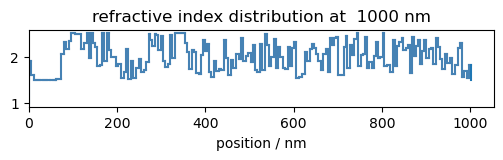

In [63]:
plot_layer_thickness(films[0], truncate_thickness=1000)


In [ ]:
# rep init
layer_ot = 10
n_size = 10000

rep = 10
inits = [
    lambda x: np.random.random(x) + 1.5, # most high freq (compared to exp)
    lambda x: np.exp(-(np.arange(x) * layer_ot / 1000)) * np.random.random(x) + 1.5, 
    lambda x: np.exp(-(np.arange(x) * layer_ot / 10000)) * np.random.random(x) + 1.5, 
    lambda x: np.zeros(x) + 1.5, # least high freq.
]

wl_min = 400
wl_max = 700
target = [get_minus_filter_spec(np.linspace(wl_min, wl_max, 500))]
get_target_spec = get_minus_filter_spec

max_step = 100
alpha=0.01

losses = []
for _ in range(rep):
    losses.append([])
    for init in inits:
        f = run_atom_exp(10, 10000, init, film_gd=True)
        losses[-1].append(calculate_RMS_f_spec(f, target))

losses = np.array(losses)

In [8]:
save('./raw_result/init', losses)

TypeError: plot_rep_violin() missing 2 required positional arguments: 'label' and 'c'

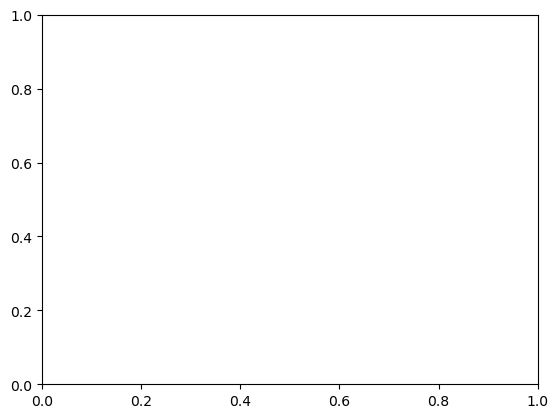

In [6]:
from analyze_utils.violin_plot import plot_rep_violin
fig, ax = plt.subplots(1, 1)
plot_rep_violin(ax, np.arange(len(inits)), losses) # when more comp resource, exp with : different OT
ax.set_xticks(np.arange(len(inits)))
ax.set_xticklabels(['uni-rand (inf decay)', '1000nm decay rand', '10000nm decay rand', 'const (0 decay)'])

ax.set_xlabel('init method')
ax.set_ylabel('loss after 100 steps GD')